In [1]:
##package imports
import numpy as np
import pandas as pd
from collections import Counter
import json
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from matplotlib import colors
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

## Always Run Load for User Data Here, and Subsequent pd.DataFrame

In [2]:
##JSON load for User data

%time
users = []
with open("yelp_academic_dataset_user.json") as f:
    i = 0
    for line in f:
        if i % 1000000 == 0:
            print(i)
        i += 1
        users.append(json.loads(line))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
0
1000000


In [3]:
users = pd.DataFrame(users)

## Skip Load for Review Data Unless Pulling a New Sample

In [3]:
##JSON load for Review data
%%time
reviews = []
with open("yelp_academic_dataset_review.json") as f:
    i = 0
    for line in f:
        if i % 1000000 == 0:
            print(i)
        i += 1
        reviews.append(json.loads(line))

0
1000000
2000000
3000000
4000000
5000000
CPU times: user 58.3 s, sys: 10.2 s, total: 1min 8s
Wall time: 1min 14s


In [4]:
##Sampling from Review Data
df = pd.DataFrame(reviews).sample(n = 50000, random_state = 30).reset_index()

In [5]:
df['text'].head()

0    Headed to Firefly for a late lunch. Per yelper...
1    This place did not look like any store I have ...
2    My Japanese friends would be appalled that a r...
3    Best bubble tea in Madison hands down. Love th...
4    I recently stopped in with my daughter while w...
Name: text, dtype: object

In [ ]:
df.to_csv(r'sample.csv')

In [78]:
##Loading CSV data for future samples
sample = pd.read_csv('sample_new.csv')

In [79]:
##Users with more than one review
mult_review_users = pd.DataFrame(sample.groupby(['user_id']).count().sort_values('index', ascending = False))
# mult_review_users = mult_review_users[mult_review_users.business_id > 1]

In [80]:
mult_review_users['index']

user_id
CxDOIDnH8gp9KXzpBHJYXw    9
ELcQDlf69kb-ihJfxZyL0A    5
U4INQZOPSUaj8hMjLlZ3KA    5
PKEzKWv_FktMm2mGPjwd0Q    5
PcvbBOCOcs6_suRDH7TSTg    4
YRcaNlwQ6XXPFDXWtuMGdA    4
O3pSxv1SyHpY4qi4Q16KzA    4
bLbSNkLggFnqwNNzzq-Ijw    4
bhJ6ivAuSpgXP4JiKWjSZQ    4
iDlkZO2iILS8Jwfdy7DP9A    4
wd3xoNaDLib8dhQ7BxUl6g    3
eY6TPklHTeOaQt9F8a_SGQ    3
YgC5A_oMsF4n7zOcSJ55tA    3
Q9mA60HnY87C1TW5kjAZ6Q    3
zTK1nPD2Hpa-ksSXsE-JzQ    3
wXi-P691AGOdonMy1TrL7w    3
LM6pxbcfdyUS8M2jWoQk1g    3
J3ucveGKKJDvtuCNnb_x0g    3
C_ZQrG6VyPTtCwUHSDJu7w    3
QJI9OSEn6ujRCtrX06vs1w    3
jzkbhkRdjWPwTIOgRGggIg    3
9zEr_yHvIKVQ7m0VDnc7gg    3
fiGqQ7pIGKyZ9G0RqWLMpg    3
27Q8zHOTOTz-w6HB2sk3oA    3
3H5Ty7TV7SZvZLa1oTUGDg    3
agN7DARhKgIyDp5WKhfqeg    3
z6gseuVl0cR7tRLQa_DXuQ    3
xhhE0txKwQtRzgQVVdKkvg    3
6xNkxlKhTNLQHvpspZu_Vg    3
bpgbVPJcG-wQ4cNBcPPIxw    3
                         ..
KzMgL2E49onbwB3g4prnVA    1
KztyqTu32E7gP5krM2a5gQ    1
Kzwz3aimUyq0hr41MwDHmQ    1
L-xH4dMTQN83yGTSj5cJmA    1
Ky46Bt6dNR-Q

In [17]:
##paring down to elites only
elites = pd.merge(mult_review_users, users, how = 'left', on = 'user_id')
elites = elites[['user_id','elite', 'name', 'review_count']]
elites = elites.drop(elites[elites.elite == 'None'].index)
print(elites)

                     user_id  \
0     CxDOIDnH8gp9KXzpBHJYXw   
1     DK57YibC5ShBmqQl97CKog   
2     bLbSNkLggFnqwNNzzq-Ijw   
3     PKEzKWv_FktMm2mGPjwd0Q   
4     PeLGa5vUR8_mcsn-fn42Jg   
5     U4INQZOPSUaj8hMjLlZ3KA   
6     dIIKEfOgo0KqUfGQvGikPg   
8     3xORNxbKdd08LUf0tclx3A   
9     d_TBs6J3twMy9GChqUEXkg   
10    bpgbVPJcG-wQ4cNBcPPIxw   
11    N3oNEwh0qgPqPP3Em6wJXw   
12    62GNFh5FySkA3MbrQmnqvg   
13    6Ki3bAL0wx9ymbdJqbSWMA   
14    y3FcL4bLy0eLlkb0SDPnBQ   
15    NfU0zDaTMEQ4-X9dbQWd9A   
16    8AwcaBJjiMpQ__FPxktwwQ   
17    fiGqQ7pIGKyZ9G0RqWLMpg   
19    UYcmGbelzRa0Q6JqzLoguw   
20    cMEtAiW60I5wE_vLfTxoJQ   
21    HJj82f-csBI7jjgenwqhvw   
22    hWDybu_KvYLSdEFzGrniTw   
23    SRK_sUnvRmMwfexoL_DLQA   
24    ObQl16Vuc4sHPGKtzSGNUw   
25    aX6_Pf3njB-H3FrqgnNJ2g   
26    j6wLUT0ZXi-x0otelYIFpA   
27    gwIqbXEXijQNgdESVc07hg   
28    TQ9A1LVp6z-fIc494RsLDQ   
29    1fNQRju9gmoCEvbPQBSo7w   
30    M9rRM6Eo5YbKLKMG5QiIPA   
31    4wp4XI9AxKNqJima-xahlg   
...     

## OR Start Here to Load the Elite data in as CSV

In [3]:
# saving elites as CSV + code to read that CSV back in
# elites.to_csv(r'elites.csv')
elites = pd.read_csv('elites.csv')

In [ ]:
##transform elite years to dataframe
elites_year = elites["elite"].str.split(", ", expand = True)
## need code to order years by column 
elites = pd.merge(elites, elites_year, how = 'left', on = 'user_id')

In [34]:
#Join Elite User data to Review data
elites_reviews = pd.merge(elites, sample, how = 'left', on = 'user_id')
elites_reviews.head()

,user_id,elite,name,review_count,Unnamed: 0,index,business_id,cool,date,funny,review_id,stars,text,useful
0,CxDOIDnH8gp9KXzpBHJYXw,"2015, 2012, 2010, 2018, 2009, 2014, 2013, 2011...",Jennifer,6082,20,5487773,y_3Csg19MnwCX8M_aMgMHA,1,2012-04-01,2,F_bNOqkm6bFZAu81_HUXug,3,Saturday at 6 and every tables at Congee Delig...,2
1,CxDOIDnH8gp9KXzpBHJYXw,"2015, 2012, 2010, 2018, 2009, 2014, 2013, 2011...",Jennifer,6082,461,5489839,9v9cMGBpUm_IzTuPfXXEOw,0,2009-11-28,0,67RY6FKzIhwRBOOzBbJSGQ,1,Firefly Seafood and Steakhouse is another Chin...,0
2,CxDOIDnH8gp9KXzpBHJYXw,"2015, 2012, 2010, 2018, 2009, 2014, 2013, 2011...",Jennifer,6082,574,5486872,7zHBqghqDi6CuTEzL0noXA,3,2010-12-09,1,RoJlxIublsZlprPtHNHpdA,3,Distill is a neat place to get some unique gif...,4
3,CxDOIDnH8gp9KXzpBHJYXw,"2015, 2012, 2010, 2018, 2009, 2014, 2013, 2011...",Jennifer,6082,782,5486914,zBd5JvFWuMGlnCYLaGsXZg,0,2015-06-23,1,IyLx8VK6eoJNCzXydNi_0A,3,"Pho Metro maybe the most ""authentic"" Pho joint...",1
4,CxDOIDnH8gp9KXzpBHJYXw,"2015, 2012, 2010, 2018, 2009, 2014, 2013, 2011...",Jennifer,6082,2313,5486548,-gPbc4oFNJ4B6hl2MaV6xQ,0,2012-08-13,1,mmyHIOJkcY9XKDzOBRsukQ,3,Rain Rain goes away...\n\nAll these rain made ...,0


In [45]:
# elites['elite'].value_counts()
## delete when Cynthia fixes transform code for elite years

None                                                                1806
2018, 2017                                                           122
2017, 2018                                                           120
2018                                                                  77
2017, 2016, 2018                                                      45
2016, 2018, 2017                                                      43
2017, 2018, 2016                                                      43
2018, 2016, 2017                                                      43
2018, 2017, 2016                                                      43
2016, 2017, 2018                                                      31
2017, 2016                                                            25
2016, 2017                                                            21
2016                                                                  17
2012, 2013                                         

## Start or Normalization of Text Process

In [60]:
review_text = elites_reviews['text']
review_users = elites_reviews['user_id']
tokenized_text = review_text.apply(sent_tokenize)
print(tokenized_text.head().values)

[list(['Saturday at 6 and every tables at Congee Delight are occupied.', 'Good luck if you are a large group without a reservation.', 'At least as a single diners like me you will feel welcome...as there are couple of small tables that are perfect for a party of 1 or 2.', "Shrimp Dumpling Noodle Soup ($4.55)\n- a little heavy on the MSG... don't drink the soup.. you will regret that\n- The noodles though have excellent bite\n- Fresh shrimps and plenty of them in the dumplings went well with the bamboo shoots and the fungus, great texture\n\nCongee Delight's vast menu is great with a big group or anytime of the day!", 'They accepts Visa and Master Card.'])
 list(['Firefly Seafood and Steakhouse is another Chinese-HK style restaurant at First Markham Place.', 'Yes price is really good... but if you come here for some good cut steak you will be disappointed!', 'I cannot really expect what you get from a $9.99 set dinner!', 'They accepts Visa and Mastercard.'])
 list(['Distill is a neat pl

In [24]:
tokenized_word=review_text.apply(word_tokenize)
print(tokenized_word.head().values)

[list(['Saturday', 'at', '6', 'and', 'every', 'tables', 'at', 'Congee', 'Delight', 'are', 'occupied', '.', 'Good', 'luck', 'if', 'you', 'are', 'a', 'large', 'group', 'without', 'a', 'reservation', '.', 'At', 'least', 'as', 'a', 'single', 'diners', 'like', 'me', 'you', 'will', 'feel', 'welcome', '...', 'as', 'there', 'are', 'couple', 'of', 'small', 'tables', 'that', 'are', 'perfect', 'for', 'a', 'party', 'of', '1', 'or', '2', '.', 'Shrimp', 'Dumpling', 'Noodle', 'Soup', '(', '$', '4.55', ')', '-', 'a', 'little', 'heavy', 'on', 'the', 'MSG', '...', 'do', "n't", 'drink', 'the', 'soup..', 'you', 'will', 'regret', 'that', '-', 'The', 'noodles', 'though', 'have', 'excellent', 'bite', '-', 'Fresh', 'shrimps', 'and', 'plenty', 'of', 'them', 'in', 'the', 'dumplings', 'went', 'well', 'with', 'the', 'bamboo', 'shoots', 'and', 'the', 'fungus', ',', 'great', 'texture', 'Congee', 'Delight', "'s", 'vast', 'menu', 'is', 'great', 'with', 'a', 'big', 'group', 'or', 'anytime', 'of', 'the', 'day', '!', 'T

In [19]:
##All Normalizing and Stemming/Lemmatization Functions

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems, lemmas

In [25]:
normalized_reviews = tokenized_word.apply(normalize)
print(normalized_reviews.head())

0    [saturday, 6, every, tables, congee, delight, ...
1    [firefly, seafood, steakhouse, another, chines...
2    [distill, neat, place, get, unique, gifts, som...
3    [pho, metro, maybe, authentic, pho, joint, imm...
4    [rain, rain, goes, away, rain, made, 6th, annu...
Name: text, dtype: object


In [26]:
text = normalized_reviews.apply(lemmatize_verbs)
text_str = [" ".join(t) for t in text.values]

In [27]:
x = np.asarray(text_str)
vectorizer = CountVectorizer(min_df=0)
vectorizer.fit(x)
X = vectorizer.transform(x)
X = X.toarray()

In [59]:
##TF-IDF Test
#tf=TfidfVectorizer()
#text_tf= tf.fit_transform(text_str)

vectorizer2 = TfidfVectorizer(ngram_range=(1,2), min_df=5)
vectors = vectorizer2.fit_transform(text_str)
print(vectors.shape)

(5904, 16211)


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(vectors, review_users, test_size=0.25, random_state=1)

In [67]:
svm = LinearSVC()
svm.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [71]:
predictions = svm.predict(X_test)
print(list(predictions[0:10]))
print(Y_test[:10])
print(accuracy_score(Y_test, predictions))

['_GCtk6kjbArSxiPPLlAfMA', '7cHcDwzMSJMRaI_pgFNeZQ', '6jz_Yr6_AP2WWLbj9gGDpA', 'kkTOV5bnE9hHb5V_zd9b9g', 'BVHZ6w_YgA1lt8Rnq4NSCg', 'keQE5jr6dgAiJGzrpYdnYw', 'ObQl16Vuc4sHPGKtzSGNUw', 'h1ovyYne78jKZPo8gFVM8g', 'YFCfAV1kKpTcBzdFz-5OxQ', 'ZsUSGU1-L1ImomLZjXxxTg']
2728    h-Zj9GUJvErqVOw-KPKNng
1817    cImvLb3Wvd5EZ8SRjKAPsw
308     TQ9A1LVp6z-fIc494RsLDQ
3565    CjHWRUKXhhley9N9NLS07Q
5501    U4qKtWpJgDdeA-nxqKU_jg
1448    ZgAzKwganIXImRAMcvdK_A
2027    8SSaCgmvsztEOg2CqeXxnw
1662    O3q-nwYZykMmacxjru01Zg
3376    fsyVPNDN20YLq4d62BD78Q
3814    EL2Ix01VF_whB5g9CHh2Ag
Name: user_id, dtype: object
0.027777777777777776


In [37]:
unique_users = elites_reviews['user_id'].unique()
unique_users

array(['CxDOIDnH8gp9KXzpBHJYXw', 'DK57YibC5ShBmqQl97CKog',
       'bLbSNkLggFnqwNNzzq-Ijw', ..., 'Zd3wzNdevk15CwMIJdbjZw',
       'lqfCumXC24HofGKkgn1Uiw', 'UXL3osX6su7tLj3noznN2g'], dtype=object)

## Naman's Iterator Code

In [157]:
#trying stuff here
review_text = subset['text']
review_user_id = subset['user_id']
for n in range(0, len(subset)):
    user_text = review_text.values[i]
    user_id = review_user_id.values[i]
    break

662


In [160]:
subset = elites_reviews[['user_id', 'text']]
subset

,user_id,text_y
0,CxDOIDnH8gp9KXzpBHJYXw,Saturday at 6 and every tables at Congee Delig...
1,CxDOIDnH8gp9KXzpBHJYXw,Firefly Seafood and Steakhouse is another Chin...
2,CxDOIDnH8gp9KXzpBHJYXw,Distill is a neat place to get some unique gif...
3,CxDOIDnH8gp9KXzpBHJYXw,"Pho Metro maybe the most ""authentic"" Pho joint..."
4,CxDOIDnH8gp9KXzpBHJYXw,Rain Rain goes away...\n\nAll these rain made ...
5,CxDOIDnH8gp9KXzpBHJYXw,3.5 Star\n\nAromaz is a Chinese bakery located...
6,CxDOIDnH8gp9KXzpBHJYXw,This LCBO is located on the East side of Prome...
7,CxDOIDnH8gp9KXzpBHJYXw,This Starbucks located right at the corner of ...
8,CxDOIDnH8gp9KXzpBHJYXw,"If you wants to be feel nostalgic, you might l..."
9,CxDOIDnH8gp9KXzpBHJYXw,I visit Saigon Star again because of the Pho-b...


In [140]:
subset.groupby(['user_id', 'text']).count()

Empty DataFrame
Columns: []
Index: [(--Qh8yKWAvIP4V4K8ZPfHA, I have been dreaming of this place for the longest amount of time, even saying this is where I would go on a day off!  So last week, on a day off, I came here for breakfast. Not a weekend because this restaurant has lineups over 45 min of wait time! 

I arrived before 11am and sat down for the baked French toast I have been dreaming of. The dish arrived with 2 small toast deeply covered in powdered sugar, maple syrup on the side, and a generous portion of berries, grapes, 1 watermelon piece and cantaloupe melon. The cantaloupe was not ripe by the way.

I admit, I was discombobulated by the actual French toast. Unlike cheaper diners, or even other restaurants that serve brunch on the weekends, these were smaller portions. And unlike those other servings, this left me satiated without the bloat. In the end, I reconciled the image in my mind with what was actually served.

I headed to the cashier to settle my bill. I don't understand why they don't accept cash. Allegedly, they have "many transactions under $4". Somehow, I have a very difficult time accepting that argument because at the very least, in one sitting during the entire day, they can collect up to $180 (they have 12 tables of 2 and using an average of $15 bill). In one sitting. There are many, many more sittings and on an average month of 26 days (they don't open on Mondays), you can do the month of how much they can earn. What is missing from my equation is the understanding of their fixed costs and variable costs, and the negotiations that occur with trusted suppliers. I wish I could have had a conversation with the manager to understand better why they don't use a POS terminal.

Before the clock over the cashier marked 11am, there was already a line up!  What an incredible racket, I mean, operation they run!), (--Qh8yKWAvIP4V4K8ZPfHA, I was lucky to visit this place because a local wine club hosts its events here. The event was held on the second floor, in the Upper Dinning Room, an elegant white room. The Club is accessible by ttc.), (-2UOdDlzg7XLuUuyOrldhA, Came to grab a late lunch to-go on a Monday, June 11, 2012.

I was warmly greeted at the door by the hostess and manager.  I asked if I could get an order to go, and they said I could at the bar.  I didn't take pics, so my memory is a bit elusive... but I remember it being very well-lit, and modern.  It matched the space of the Crystals shopping center.  It was very lively, and I was surprised there were so many patrons at that hour (around 2pm).

I got the spaghetti and meatballs, as well as the grilled meatballs.  My friend, Arvin T, had been searching for the "best meatball," and so I joined him in his search.

I was very tempted to have a cocktail, having glanced a number of tasty looking handcrafted cocktails... next time!

I forget how long the bartender said the wait would be, and I had made a note in my phone (only to have deleted it, it seems)... but I remember it taking 3-4 minutes longer than he said.  Which was fine for me, but for those that are nit-picky...

Fast forward, I'm sitting on the couch in Veer Towers (that's why I chose to get it to go -- it was 8 minutes flat, from bar to doorstep), with Mad Men on Netflix... I dig into the spaghetti... it's cooked al dente, thumbs up.  I take a bite of the meatball -- my teeth sink through more easily than anticipated; it's a very soft texture, and I don't like it.  On top of that, it was surprisingly sweet tasting, not in a good way.  Disappointed, I wash it down with water, and give it a second go.  Same disappointment.

I open up the grilled meatballs and cross my fingers... The texture is more firm, like I'm used to.  However, this time it's way too salty!  I quickly grab the water, rinse, and repeat.  Salty!  Deja Vu.  Einstein's attributed quote came to mind: "Insanity: Doing the same thing over and over again and expecting different results."  (He didn't really say that btw, but who k

In [165]:
#Contd
collection = []
review_text = subset['text']
review_user_id = subset['user_id']
for i in range(0, len(subset.values)):
    user_text = review_text.values[i]
    user_id = review_user_id.values[i]
    collection = user_id + user_text
    test_words = review_text.apply(word_tokenize)
    normalized_test = test_words.apply(normalize)
    lem_test = normalized_test.apply(lemmatize_verbs)
    test_dictionary = corpora.Dictionary(lem_test)
    test_corpus = [test_dictionary.doc2bow(text) for text in lem_test]
    lsi = models.LsiModel(test_corpus, id2word=test_dictionary, num_topics=2)
    index = similarities.MatrixSimilarity(lsi[test_corpus])
    vec_corpus = lsi[test_corpus]
    sims = index[vec_corpus] # perform a similarity query against the corpus
    #print(collection)
    print(test_words)
    print(sims)
    break
    


C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0       [Saturday, at, 6, and, every, tables, at, Cong...
1       [Firefly, Seafood, and, Steakhouse, is, anothe...
2       [Distill, is, a, neat, place, to, get, some, u...
3       [Pho, Metro, maybe, the, most, ``, authentic, ...
4       [Rain, Rain, goes, away, ..., All, these, rain...
5       [3.5, Star, Aromaz, is, a, Chinese, bakery, lo...
6       [This, LCBO, is, located, on, the, East, side,...
7       [This, Starbucks, located, right, at, the, cor...
8       [If, you, wants, to, be, feel, nostalgic, ,, y...
9       [I, visit, Saigon, Star, again, because, of, t...
10      [There, are, few, things, that, this, location...
11      [I, do, n't, even, remember, when, I, was, the...
12      [I, was, contemplating, should, I, write, a, r...
13      [I, love, my, lunch, experience, at, Porcello,...
14      [I, have, no, idea, why, D, &, R, Wing, 's, is...
15      [I, come, here, because, of, the, set, menu, a...
16      [My, previous, review, was, based, on, the, ol...
17      [We, w

In [38]:
##only reviews for one user with multiple reviews
elites_reviews.loc[elites_reviews['user_id'] == "dIIKEfOgo0KqUfGQvGikPg", ['user_id','text_y']]

/Users/icross/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,user_id,text_y
130,dIIKEfOgo0KqUfGQvGikPg,NaN
131,dIIKEfOgo0KqUfGQvGikPg,NaN
132,dIIKEfOgo0KqUfGQvGikPg,NaN
133,dIIKEfOgo0KqUfGQvGikPg,NaN
134,dIIKEfOgo0KqUfGQvGikPg,NaN
135,dIIKEfOgo0KqUfGQvGikPg,NaN
136,dIIKEfOgo0KqUfGQvGikPg,NaN
137,dIIKEfOgo0KqUfGQvGikPg,NaN
138,dIIKEfOgo0KqUfGQvGikPg,NaN
139,dIIKEfOgo0KqUfGQvGikPg,NaN


In [39]:
## store that users reviews into a list
test_user = elites_reviews.loc[elites_reviews['user_id'] == "dIIKEfOgo0KqUfGQvGikPg", ['user_id','text']]
test_user = test_user['text']
print(test_user)

130    Sometimes as a parent, you have to follow your...
131    I just returned home from another visit to The...
132    I rarely do fast food, but every now and then,...
133    I'm a huge fan of Matt's Big Breakfast -- this...
134    Costco serves a purpose... and it's great for ...
135    As I start to write this review, the Toys R Us...
136    I'm a huge fan of AJ's in general... \nThe two...
137    I was in Bomberos for breakfast this morning, ...
138    I'm a cheater... there, I admit it!\n\nYes, I ...
139    Tonight was my second visit to Pho Thanh and a...
140    So it's been just over 2 weeks since Baby M wa...
Name: text, dtype: object


In [67]:
len(test_user)

11

In [40]:
##running test user's review through the normalization process
test_words = test_user.apply(word_tokenize)
print(test_words)

130    [Sometimes, as, a, parent, ,, you, have, to, f...
131    [I, just, returned, home, from, another, visit...
132    [I, rarely, do, fast, food, ,, but, every, now...
133    [I, 'm, a, huge, fan, of, Matt, 's, Big, Break...
134    [Costco, serves, a, purpose, ..., and, it, 's,...
135    [As, I, start, to, write, this, review, ,, the...
136    [I, 'm, a, huge, fan, of, AJ, 's, in, general,...
137    [I, was, in, Bomberos, for, breakfast, this, m...
138    [I, 'm, a, cheater, ..., there, ,, I, admit, i...
139    [Tonight, was, my, second, visit, to, Pho, Tha...
140    [So, it, 's, been, just, over, 2, weeks, since...
Name: text, dtype: object


In [41]:
normalized_test = test_words.apply(normalize)
print(normalized_test)

130    [sometimes, parent, follow, intuition, even, m...
131    [returned, home, another, visit, covenant, tim...
132    [rarely, fast, food, every, find, convenient, ...
133    [huge, fan, matt, big, breakfast, location, pa...
134    [costco, serves, purpose, great, stocking, eve...
135    [start, write, review, toys, r, us, song, pops...
136    [huge, fan, aj, general, two, locations, frequ...
137    [bomberos, breakfast, morning, told, carry, co...
138    [cheater, admit, yes, cheated, rose, could, nt...
139    [tonight, second, visit, pho, thanh, left, ful...
140    [2, weeks, since, baby, born, going, well, mat...
Name: text, dtype: object


In [42]:
lem_test = normalized_test.apply(lemmatize_verbs)
print(lem_test)

130    [sometimes, parent, follow, intuition, even, m...
131    [return, home, another, visit, covenant, time,...
132    [rarely, fast, food, every, find, convenient, ...
133    [huge, fan, matt, big, breakfast, location, pa...
134    [costco, serve, purpose, great, stock, everyth...
135    [start, write, review, toy, r, us, song, pop, ...
136    [huge, fan, aj, general, two, locations, frequ...
137    [bomberos, breakfast, morning, tell, carry, co...
138    [cheater, admit, yes, cheat, rise, could, nt, ...
139    [tonight, second, visit, pho, thanh, leave, fu...
140    [2, weeks, since, baby, bear, go, well, matter...
Name: text, dtype: object


In [44]:
## establish dictionary and corpus for test user
test_dictionary = corpora.Dictionary(lem_test)
print(test_dictionary.token2id)

{'2017': 0, '30minute': 1, 'admit': 2, 'age': 3, 'also': 4, 'amongst': 5, 'amount': 6, 'amy': 7, 'annunciate': 8, 'anything': 9, 'appear': 10, 'appropriate': 11, 'articulation': 12, 'average': 13, 'background': 14, 'balance': 15, 'barriers': 16, 'bite': 17, 'bring': 18, 'catch': 19, 'certain': 20, 'child': 21, 'clinical': 22, 'come': 23, 'communication': 24, 'company': 25, 'concern': 26, 'conclude': 27, 'consider': 28, 'could': 29, 'curious': 30, 'date': 31, 'daugher': 32, 'daughter': 33, 'decide': 34, 'definitely': 35, 'development': 36, 'difficulty': 37, 'director': 38, 'discuss': 39, 'disorder': 40, 'due': 41, 'easily': 42, 'elementary': 43, 'enough': 44, 'enter': 45, 'environment': 46, 'evaluation': 47, 'even': 48, 'every': 49, 'everything': 50, 'eye': 51, 'field': 52, 'find': 53, 'follow': 54, 'forbid': 55, 'four': 56, 'friendly': 57, 'get': 58, 'go': 59, 'god': 60, 'graduate': 61, 'grateful': 62, 'great': 63, 'grow': 64, 'hand': 65, 'hear': 66, 'help': 67, 'hit': 68, 'home': 69, 

In [45]:
test_corpus = [test_dictionary.doc2bow(text) for text in lem_test]
print(test_corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 5), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 5), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 3), (99, 1), (100, 1), (101, 3), (102, 1), (103, 2), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [46]:
## lsi and similarity scoring
lsi = models.LsiModel(test_corpus, id2word=test_dictionary, num_topics=2)

In [47]:
## creating index to apply similarity score
index = similarities.MatrixSimilarity(lsi[test_corpus])
vec_corpus = lsi[test_corpus]

/Users/icross/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [48]:
sims = index[vec_corpus] # perform a similarity query against the corpus
print(sims) # figure out a better way to print this index

[[1.         0.8540681  0.73469085 0.90691566 0.99874264 0.20265122
  0.9519807  0.6652108  0.9878866  0.99949336 0.999684  ]
 [0.8540681  1.         0.9803544  0.993718   0.8269177  0.68244636
  0.9723079  0.9565166  0.9244398  0.8370792  0.84072256]
 [0.73469085 0.9803544  0.99999994 0.9521217  0.69975775 0.8132119
  0.9071098  0.99525696 0.8310641  0.7127259  0.71740526]
 [0.9069157  0.993718   0.9521217  0.99999994 0.88465434 0.59635794
  0.99235433 0.91786516 0.96130806 0.89304626 0.8960383 ]
 [0.99874264 0.82691777 0.6997578  0.88465434 1.         0.15330511
  0.93543553 0.6269434  0.97886515 0.9998322  0.9996872 ]
 [0.20265128 0.68244636 0.8132119  0.59635794 0.15330514 1.
  0.49272567 0.8659691  0.3521543  0.17138013 0.17797114]
 [0.9519807  0.9723079  0.9071098  0.99235433 0.93543553 0.49272567
  1.         0.8618624  0.98795784 0.9417537  0.94398373]
 [0.6652108  0.9565166  0.99525696 0.91786516 0.6269434  0.86596906
  0.8618624  1.         0.77301705 0.6411085  0.6462314 ]
 

In [52]:
# vec_lsi = lsi[test_corpus[0]]
# print(vec_lsi)

similarity_test[0:1]

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.854068,0.734691,0.906916,0.998743,0.202651,0.951981,0.665211,0.987887,0.999493,0.999684


In [50]:
##similarity matrix for test_user
similarity_test = pd.DataFrame(data=sims[0:,0:],index=range(len(lem_test)),columns=range(len(lem_test)))
similarity_test

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.854068,0.734691,0.906916,0.998743,0.202651,0.951981,0.665211,0.987887,0.999493,0.999684
1,0.854068,1.000000,0.980354,0.993718,0.826918,0.682446,0.972308,0.956517,0.924440,0.837079,0.840723
2,0.734691,0.980354,1.000000,0.952122,0.699758,0.813212,0.907110,0.995257,0.831064,0.712726,0.717405
3,0.906916,0.993718,0.952122,1.000000,0.884654,0.596358,0.992354,0.917865,0.961308,0.893046,0.896038
4,0.998743,0.826918,0.699758,0.884654,1.000000,0.153305,0.935436,0.626943,0.978865,0.999832,0.999687
5,0.202651,0.682446,0.813212,0.596358,0.153305,1.000000,0.492726,0.865969,0.352154,0.171380,0.177971
6,0.951981,0.972308,0.907110,0.992354,0.935436,0.492726,1.000000,0.861862,0.987958,0.941754,0.943984
7,0.665211,0.956517,0.995257,0.917865,0.626943,0.865969,0.861862,1.000000,0.773017,0.641109,0.646231
8,0.987887,0.924440,0.831064,0.961308,0.978865,0.352154,0.987958,0.773017,1.000000,0.982447,0.983674
9,0.999493,0.837079,0.712726,0.893046,0.999832,0.171380,0.941754,0.641109,0.982447,1.000000,0.999978


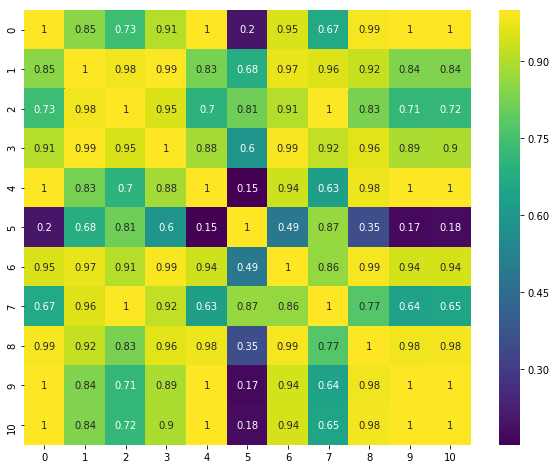

In [77]:
plt.figure(figsize=(10,8))
sb.heatmap(similarity_test,cmap='viridis',annot=True)
plt.show()

In [78]:
test_user.iloc[0]

'Sometimes as a parent, you have to follow your intuition, even if it means admitting that your child is not hitting milestones, considered "normal," or god forbid "below average" when it comes to development.\n\nAfter discussing it amongst ourselves for some time and even hearing that her own teachers were not concerned, we decided it wouldn\'t hurt to schedule a speech evaluation for our daughter.  This was because we noticed that at three and four years old, she was having difficulty pronouncing certain letters and sounds.\n\nWe were referred to PSLS from our pre-school director and had an initial evaluation in July of 2017.    Sure enough, the evaluation concluded that speech therapy "appears medically necessary due to an articulation disorder."  It was recommended that our daughter participate in 30-minute sessions of speech therapy for a minimum of two sessions per week, as well as practicing at home.\n\nAs a result of the evaluation, we also learned that there was no reason our 

In [79]:
test_user.iloc[1]

"I just returned home from another visit to The Covenant... this time it was for a Mother's Day ladies brunch and it was great.\n\nI made a 10:45 reservation via Yelp for four people (me, my mother-in-law, my grandmother-in-law, and my daughter).  I wasn't sure how it would work out for my 5 year old, as I didn't know if The Covenant offered a kids menu, but they did, and it worked out just fine.\n\nThis time my party was seated in Gabby's section, and she was fabulous.  My daughter did the kids pasta and fruit and the adults shared a hummus board, avocado toast, and a frittata.  It was more than enough food.  \n\nThe special chocolate covered strawberries for the mothers at the end of the meal were a very nice (and delicious surprise).  Thanks so much and Happy Mother's Day to those reading this today ;)"

In [80]:
lem_test.iloc[0]

['sometimes',
 'parent',
 'follow',
 'intuition',
 'even',
 'mean',
 'admit',
 'child',
 'hit',
 'milestones',
 'consider',
 'normal',
 'god',
 'forbid',
 'average',
 'come',
 'development',
 'discuss',
 'amongst',
 'time',
 'even',
 'hear',
 'teachers',
 'concern',
 'decide',
 'would',
 'nt',
 'hurt',
 'schedule',
 'speech',
 'evaluation',
 'daughter',
 'notice',
 'three',
 'four',
 'years',
 'old',
 'difficulty',
 'pronounce',
 'certain',
 'letter',
 'sound',
 'refer',
 'psls',
 'preschool',
 'director',
 'initial',
 'evaluation',
 'july',
 '2017',
 'sure',
 'enough',
 'evaluation',
 'conclude',
 'speech',
 'therapy',
 'appear',
 'medically',
 'necessary',
 'due',
 'articulation',
 'disorder',
 'recommend',
 'daughter',
 'participate',
 '30minute',
 'sessions',
 'speech',
 'therapy',
 'minimum',
 'two',
 'sessions',
 'per',
 'week',
 'well',
 'practice',
 'home',
 'result',
 'evaluation',
 'also',
 'learn',
 'reason',
 'daughter',
 'could',
 'nt',
 'easily',
 'catch',
 'age',
 'appro

In [81]:
lem_test.iloc[1]

['return',
 'home',
 'another',
 'visit',
 'covenant',
 'time',
 'mother',
 'day',
 'ladies',
 'brunch',
 'great',
 'make',
 '1045',
 'reservation',
 'via',
 'yelp',
 'four',
 'people',
 'motherinlaw',
 'grandmotherinlaw',
 'daughter',
 'nt',
 'sure',
 'would',
 'work',
 '5',
 'year',
 'old',
 'nt',
 'know',
 'covenant',
 'offer',
 'kid',
 'menu',
 'work',
 'fine',
 'time',
 'party',
 'seat',
 'gabby',
 'section',
 'fabulous',
 'daughter',
 'kid',
 'pasta',
 'fruit',
 'adults',
 'share',
 'hummus',
 'board',
 'avocado',
 'toast',
 'frittata',
 'enough',
 'food',
 'special',
 'chocolate',
 'cover',
 'strawberries',
 'mother',
 'end',
 'meal',
 'nice',
 'delicious',
 'surprise',
 'thank',
 'much',
 'happy',
 'mother',
 'day',
 'read',
 'today']